In [1]:
import cv2
import os
import shutil

import json
from tqdm.auto import tqdm
import numpy as np

import matplotlib.pyplot as plt

import tifffile as tiff
from ultralytics import YOLO

import glob
import yaml

from collections import Counter
import pandas as pd
import random



c:\Users\Domagoj\Desktop\MYSUNTEST\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
def read_classes_from_file(file_path):
    with open(file_path, 'r') as f:
        classes = [line.strip().replace('- ', '') for line in f if line.strip()]
    return classes

In [6]:
class_ids = read_classes_from_file('classes.txt')
print(class_ids)
class_mapping = dict(zip(class_ids, range(len(class_ids))))
# Path to images and annotations
path_images = "image"
path_annot = "info.json"

print(os.path.exists(path_images))
print(os.path.exists(path_annot))

['chair', 'table', 'pillow', 'desk', 'sofa_chair', 'cabinet', 'lamp', 'sofa', 'door', 'bed', 'box', 'garbage_bin', 'monitor', 'shelf', 'counter', 'computer', 'endtable', 'sink', 'bookshelf', 'night_stand', 'drawer', 'dresser', 'paper', 'painting', 'keyboard', 'coffee_table', 'cpu', 'ottoman', 'tv', 'picture', 'stool', 'recycle_bin', 'whiteboard', 'bench', 'toilet', 'mirror', 'fridge', 'printer', 'curtain', 'bottle', 'laptop', 'vanity', 'towel', 'plant', 'books']
True
True


In [7]:
def coco_to_yolo(x1, y1, w, h, image_w, image_h):
    x_center = (x1 + (w / 2)) / image_w
    y_center = (y1 + (h / 2)) / image_h
    w = w / image_w
    h = h / image_h
    return x_center, y_center, w, h

In [8]:
CLIPPING_THRESHOLD = 1.05

In [ ]:
def parse_custom_json_to_yolov8(annotation_json, path_images, class_mapping):
    with open(annotation_json, "r") as f:
        data = json.load(f)

    image_paths = []
    bbox = []
    classes = []
    for item in tqdm(data, desc="Processing Images"):
        image_path = item['image']
        image = cv2.imread(image_path)
        img_width, img_height = image.shape[1], image.shape[0]
        boxes = []
        class_ids = []

        for ann in item["annotations"]:
            class_name = ann["classname"]
            if class_name not in class_mapping:
                continue  # Skip unknown classes
            xmin, ymin, width, height = ann["bbox"]
            x_center, y_center, width, height = coco_to_yolo(xmin, ymin, width, height, img_width, img_height)
            if (x_center > 1.0 and x_center <= CLIPPING_THRESHOLD)  or (y_center > 1.0 and y_center <= CLIPPING_THRESHOLD) or (width > 1.0 and width <= CLIPPING_THRESHOLD) or (height > 1.0 and height <= CLIPPING_THRESHOLD):
              x_center = np.clip(x_center, 0, 1)
              y_center = np.clip(y_center, 0, 1)
              width = np.clip(width, 0, 1)
              height = np.clip(height, 0, 1)
            elif x_center > CLIPPING_THRESHOLD or y_center > CLIPPING_THRESHOLD or width > CLIPPING_THRESHOLD or height > CLIPPING_THRESHOLD:
              continue
            boxes.append([x_center, y_center, width, height])
            class_ids.append(class_mapping[class_name])
        if len(boxes) == 0:
            continue # If picture doesn't have any box from the selected classes, skip the image
        image_paths.append(image_path)
        bbox.append(boxes)
        classes.append(class_ids)

    return image_paths, bbox, classes

image_paths, bbox, classes = parse_custom_json_to_yolov8(path_annot, path_images, class_mapping)

# Print an example
print('Image path: ', image_paths[:3] ,'\n')
print('Bounding boxes: ', bbox[:3] , '\n')
print('Classes: ',classes[:3], '\n')


print(f"Number of images: {len(image_paths)}")

Processing Images: 100%|██████████| 10334/10334 [00:13<00:00, 790.30it/s]

Image path:  ['image/00000.jpg', 'image/00001.jpg', 'image/00002.jpg'] 

Bounding boxes:  [[[0.6863013698630137, 0.5886792452830188, 0.473972602739726, 0.6037735849056604], [0.8516859852476292, 0.5702341137123745, 0.13476428276904753, 0.10033444816053516], [0.672000274888899, 0.7976588628762542, 0.4334310716085582, 0.39464882943143814], [0.15273972602739727, 0.5009433962264151, 0.30273972602739724, 0.9981132075471698], [0.8790030695927062, 0.4665551839464883, 0.07527374352865716, 0.1772575250836121], [0.6727647035866213, 0.48021181716833894, 0.20994809350973734, 0.09085841694537346]], [[0.3424657534246575, 0.620754716981132, 0.6821917808219178, 0.7584905660377359], [0.7678082191780822, 0.7556603773584906, 0.26986301369863014, 0.36792452830188677], [0.553626242726898, 0.548494983277592, 0.1786721729110981, 0.13691218916668235], [0.7994491848156039, 0.48388396454472204, 0.1023809786628107, 0.28444802578565676], [0.3994364777569066, 0.5016722408026756, 0.13779951436294496, 0.1103678929765

In [24]:
content_dir = './content'   
rgb_dir = './content_processed/RGB'
depth_dir = './content_processed/Depth'
rgbd_dir = './content_processed/RGBD'

#!mkdir /content/datasets
#!mkdir /content/datasets/content
os.makedirs(rgb_dir, exist_ok=True)
os.makedirs(depth_dir, exist_ok=True)
os.makedirs(rgbd_dir, exist_ok=True)

os.makedirs(os.path.join(rgb_dir, 'train', 'images'), exist_ok=True)
os.makedirs(os.path.join(rgb_dir, 'val', 'images'), exist_ok=True)
os.makedirs(os.path.join(rgb_dir, 'train', 'labels'), exist_ok=True)
os.makedirs(os.path.join(rgb_dir, 'val', 'labels'), exist_ok=True)

os.makedirs(os.path.join(depth_dir, 'train', 'images'), exist_ok=True)
os.makedirs(os.path.join(depth_dir, 'val', 'images'), exist_ok=True)
os.makedirs(os.path.join(depth_dir, 'train', 'labels'), exist_ok=True)
os.makedirs(os.path.join(depth_dir, 'val', 'labels'), exist_ok=True)

os.makedirs(os.path.join(rgbd_dir, 'train', 'images'), exist_ok=True)
os.makedirs(os.path.join(rgbd_dir, 'val', 'images'), exist_ok=True)
os.makedirs(os.path.join(rgbd_dir, 'train', 'labels'), exist_ok=True)
os.makedirs(os.path.join(rgbd_dir, 'val', 'labels'), exist_ok=True)

In [ ]:
#shutil.rmtree("./content_processed", ignore_errors=True)

In [11]:
SPLIT_SIZE = 0.2

In [12]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import numpy as np

def multilabel_stratified_split(image_paths, bbox, classes, class_mapping, test_size=0.2, random_state=42):
    # Create a multi-label binary matrix - each row is an image, each column is a class
    n_classes = len(class_mapping)
    y_multilabel = np.zeros((len(image_paths), n_classes), dtype=int)
    
    # Fill the matrix: 1 if the image has that class, 0 otherwise
    for i, class_list in enumerate(classes):
        for class_id in class_list:
            y_multilabel[i, class_id] = 1
    
    # Create cross-validation split
    mskf = MultilabelStratifiedKFold(n_splits=int(1/test_size), random_state=random_state, shuffle=True)
    
    # Get train and test indices
    train_indices, test_indices = next(mskf.split(image_paths, y_multilabel))
    
    # Create lists for train and test sets
    train_image_paths = [image_paths[i] for i in train_indices]
    train_bbox = [bbox[i] for i in train_indices]
    train_classes = [classes[i] for i in train_indices]
    
    test_image_paths = [image_paths[i] for i in test_indices]
    test_bbox = [bbox[i] for i in test_indices]
    test_classes = [classes[i] for i in test_indices]
    
    return (train_image_paths, train_bbox, train_classes, 
            test_image_paths, test_bbox, test_classes)

In [13]:
train_image_paths, train_bbox, train_classes, test_image_paths, test_bbox, test_classes = multilabel_stratified_split(image_paths, bbox, classes, class_mapping, test_size=SPLIT_SIZE)
print(f"Number of training images: {len(train_image_paths)}")
print(f"Number of testing images: {len(test_image_paths)}")

Number of training images: 8061
Number of testing images: 2054


In [ ]:
def count_classes(class_lists, class_mapping=None):
    """
    Count occurrences of each class in the dataset
    
    Args:
        class_lists: List of lists containing class IDs for each image
        class_mapping: Optional dictionary mapping class IDs to class names
        
    Returns:
        Counter object with class counts
    """
    # Flatten the list of lists to count all classes
    all_classes = [class_id for sublist in class_lists for class_id in sublist]
    return Counter(all_classes)

full_dataset_counts = count_classes(classes)

train_image_paths, train_bbox, train_classes, test_image_paths, test_bbox, test_classes = multilabel_stratified_split(
    image_paths, bbox, classes, class_mapping, test_size=SPLIT_SIZE
)

# Count classes in full dataset
full_dataset_counts = count_classes(classes)

# After splitting
train_counts = count_classes(train_classes)
val_counts = count_classes(test_classes)

# Create a summarized table
print("\n=== Summary Table ===")
df = pd.DataFrame({
    'Full Dataset': pd.Series(full_dataset_counts),
    'Training Set': pd.Series(train_counts),
    'Validation Set': pd.Series(val_counts)
}).fillna(0).astype(int)


if class_mapping:
    inverse_mapping = {v: k for k, v in class_mapping.items()}
    df['Class Name'] = df.index.map(lambda x: inverse_mapping.get(x, "Unknown"))
    cols = df.columns.tolist()
    df = df[['Class Name'] + cols[:-1]]

print(df)




=== Summary Table ===
      Class Name  Full Dataset  Training Set  Validation Set
0          chair         24590         19668            4922
1          table          6591          5310            1281
2         pillow          4655          3674             981
3           desk          3616          2954             662
4     sofa_chair          2090          1660             430
5        cabinet          1848          1470             378
6           lamp          1752          1390             362
7           sofa          1720          1394             326
8           door          1580          1254             326
9            bed          1548          1213             335
10           box          1451          1143             308
11   garbage_bin          1302          1050             252
12       monitor          1299          1058             241
13         shelf          1299          1033             266
14       counter           926           731             195
1

In [ ]:
def structure_data_yolo(image_paths, bbox, classes, output_dir, data_type):
    for i, image_path in enumerate(image_paths):
        # Create a text file with the same name as the image but with a .txt extension
        txt_file_path = os.path.splitext(os.path.basename(image_path))[0] + '.txt'
        txt_file_path = os.path.join(output_dir, data_type, 'labels',  txt_file_path)

        with open(txt_file_path, 'w') as f:
            for j, box in enumerate(bbox[i]):
                class_id = classes[i][j]
                x_center, y_center, width, height = box
                f.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

In [ ]:
# .tiff image processing
for data_type, img_paths, bboxes, classes_list in zip(
    ['train', 'val'],
    [train_image_paths, test_image_paths],
    [train_bbox, test_bbox],
    [train_classes, test_classes]
):
    for image_path in tqdm(img_paths, 'Processing Images'):
        # RGB image
        rgb_image_path = os.path.join('./', image_path)
        shutil.copy(rgb_image_path, os.path.join(rgb_dir, data_type, 'images'))

        # Depth image
        depth_image_path = os.path.join('./depth', os.path.splitext(os.path.basename(image_path))[0] + '.png')
        shutil.copy(depth_image_path, os.path.join(depth_dir, data_type, 'images'))

        # RGBD image
        rgb_image = cv2.imread(rgb_image_path)
        depth_image = cv2.imread(depth_image_path, cv2.IMREAD_GRAYSCALE)
        depth_image = depth_image.reshape(rgb_image.shape[0], rgb_image.shape[1], 1)
        rgbd_image = np.concatenate((rgb_image, depth_image), axis=2)
        output_filename = os.path.splitext(os.path.basename(image_path))[0] + '.tiff'
        tiff.imwrite(os.path.join(rgbd_dir, data_type, 'images', output_filename), rgbd_image)
    structure_data_yolo(img_paths, bboxes, classes_list, rgb_dir, data_type)
    structure_data_yolo(img_paths, bboxes, classes_list, depth_dir, data_type)
    structure_data_yolo(img_paths, bboxes, classes_list, rgbd_dir, data_type)

Processing Images: 100%|██████████| 2054/2054 [00:15<00:00, 131.58it/s]


Image shape: (441, 591, 4)


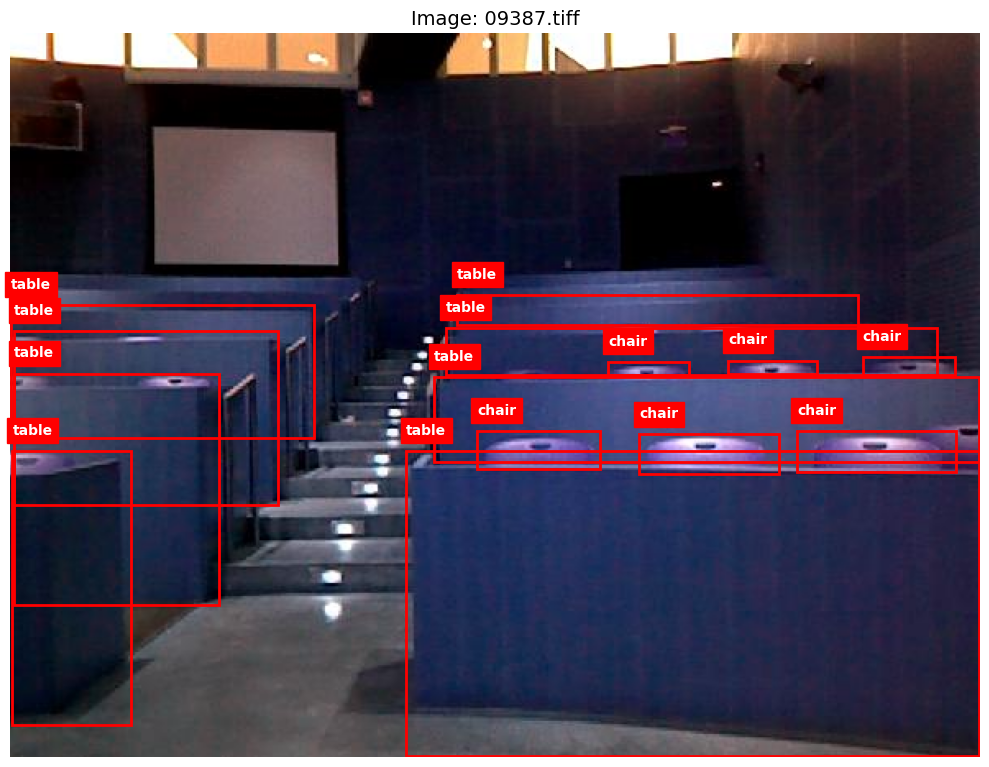

Found True annotations in ./content_processed/RGBD\train\labels\09387.txt


In [ ]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import tifffile as tiff
import numpy as np

# Get random image from train set
images = os.listdir(rgbd_dir + '/train/images')
random_index = random.randint(0, len(images) - 1)
image_filename = images[random_index]
image_path = os.path.join(rgbd_dir, 'train', 'images', image_filename)
image = tiff.imread(image_path)
print(f"Image shape: {image.shape}")

# Get corresponding label file
base_filename = os.path.splitext(image_filename)[0]
label_path = os.path.join(rgbd_dir, 'train', 'labels', base_filename + '.txt')

# Create figure and axis for plotting
fig, ax = plt.subplots(1, figsize=(10, 10))

if image.shape[2] == 4:  # RGBD image
    display_image = image[:, :, :3]  # Take only RGB channels
else:
    display_image = image
    
ax.imshow(display_image)

inverse_mapping = {v: k for k, v in class_mapping.items()}

# Parse label file and draw bounding boxes
if os.path.exists(label_path):
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 5:
                class_id = int(parts[0])
                x_center, y_center, width, height = map(float, parts[1:5])
                
                # Convert normalized coordinates to pixel values
                img_height, img_width = image.shape[0], image.shape[1]
                x1 = int((x_center - width/2) * img_width)
                y1 = int((y_center - height/2) * img_height)
                box_width = int(width * img_width)
                box_height = int(height * img_height)
                
                # Create rectangle patch for the bounding box
                rect = patches.Rectangle((x1, y1), box_width, box_height, 
                                        linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                
                # Add class label text with actual class name
                class_name = inverse_mapping.get(class_id, f"Unknown: {class_id}")
                ax.text(x1, y1-10, class_name, color='white', weight='bold',
                        fontsize=10, backgroundcolor="red")

plt.title(f"Image: {image_filename}", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"Found {os.path.exists(label_path)} annotations in {label_path}")